# Doodling with `osmnx`

A notebook demonstrating a quick play with Geoff Boeing's [`osmnx`](https://github.com/gboeing/osmnx) package, in part drawing on examples found in the [`gboeing/osmnx-examples`](https://github.com/gboeing/osmnx-examples) notebooks.

In [29]:
# brew install spatialindex
# pip install osmnx
import osmnx as ox

import networkx as nx

import folium

#Enable inline plotting of maps
%matplotlib inline

Let's start with a simple demo - grab all the driveable roads on the Isle of Wight from OpenStreetMap and render them:

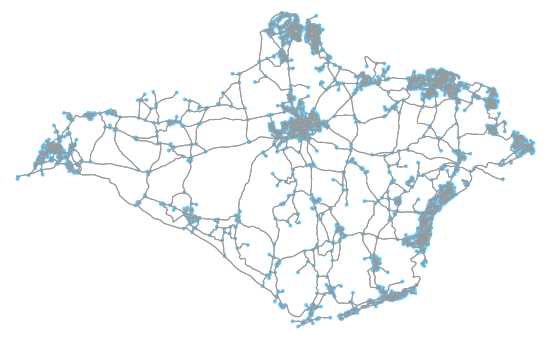

In [4]:
#Note - this may take some time...
G = ox.graph_from_place('Isle of Wight, UK', network_type='drive')
#The projection step projects to 
#ox.plot_graph(ox.project_graph(G));
ox.plot_graph(G);

## Simple Route Planning

The routes are represented internally as a `networkx` graph. Finding the shortest distance between provides a way of generating simple routes.

Using as `osmnx` utility method, we can geolocate addresses to access latitude/longitude co-ordinates of a location:

In [5]:
origin = ox.utils.geocode('Pointer Inn, Newchurch, Isle of Wight')
destination = ox.utils.geocode('Taverners, Godshill, Isle of Wight')

We can then use another utility function to find the nearest node on the route graph to each location:

In [6]:
origin_node =  ox.get_nearest_node(G, origin) 
destination_node = ox.get_nearest_node(G, destination )  

The route is then found as the shortest path between those nodes over the graph representation:

In [10]:
route = nx.shortest_path(G, origin_node, destination_node)

Plotting the route highlights it on the whole graph:

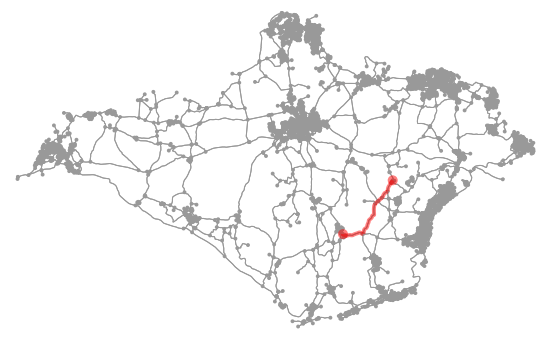

In [11]:
ox.plot_graph_route(G, route);

Alternatively, we can plot the route on an interactive map:

In [12]:
# plot the route with folium
ox.plot_route_folium(G, route, route_width=3, route_color='#AA1111',
                     tiles='openstreetmap', popup_attribute='name')

## Searching for Roads Within a Particular Boundaried Area

As well as search for roads in a particular area searched for by name, we can also pull back roads or paths that are within a particular boundary specified using a shapefile.

For example, using parish boundary line data made available as Ordnance Survey BoundaryLine data and served via a datasette ([Trying out SpatiaLite support in datasette](https://blog.ouseful.info/2018/06/28/trying-out-spatialite-support-in-datasette/)), we can pull back the boundary from the parish I live in an use that to filter the OSM routes request.

First, grab the boundary data. There is actually another parish with the same name as the one I live in, so provide an added filter on the query to limit the results to a particular county. (We could also write a query to pull back a shapefile based on an ONS geography code.

*(Note to self - add in a database table that supports ONS Geography lookup codes, eg as per [ONS Register of Geographic Codes](https://github.com/psychemedia/parlihacks/blob/master/notebooks/ONS%20Register%20of%20Geographic%20Codes.ipynb).)*

In [22]:
import requests, json

def get_geojson(region_type, region, county=None, code=None,
                col='wgs84',json_url = "http://localhost:8001/adminboundaries.json"):
    
    q='SELECT AsGeoJSON({col}) FROM {table} WHERE name LIKE "%{region}%"'.format(col=col,table=region_type,region=region)
    
    if county is not None: q='{} AND FILE_NAME LIKE "%{}%"'.format(q, county)
    if code is not None: q='{} AND CODE LIKE "%{}%"'.format(q, code)
        
    params = {'sql': q}
    #for example: SELECT AsGeoJSON(wgs84) FROM district_borough_unitary_region WHERE name LIKE "%wight%" 
    r = requests.get(json_url, params=params)
    results = r.json()
    return json.loads(results['rows'][0][0])

### Firing up the datasette server

One way of starting the datasette server is to use a containerised version of it:

In [19]:
%%bash
#docker run -d -p 8003:8001 -v `pwd`:/mnt datasetteproject/datasette \
#    datasette -p 8001 -h 0.0.0.0 /mnt/adminboundaries.db  --load-extension=/usr/local/lib/mod_spatialite.so \
#                --config sql_time_limit_ms:10000
#https://datasette.readthedocs.io/en/latest/installation.html
#Assuming an appropriate database is in the pwd (present working directory)

#locally on OS/X
#datasette -p 8003 adminboundaries.db  --load-extension=/usr/local/lib/mod_spatialite.dylib
#locally in Mybinder, something likedatasette -p 8003 adminboundaries.db  --load-extension=/usr/lib/x86_64-linux-gnu/mod_spatialite.so

b61f0beb84433d45e551641424d410cda2ae45cc7aec86e1b853c31420a6f4ad


Now we can pull back a geojson boundary from the datasette:

In [23]:
gj=get_geojson('parish_region', 'newchurch', 'wight', json_url = "http://localhost:8003/adminboundaries.json")

The `osmnx` package looks like it wants a `shapely` geometry to use as a filter when querying OpenStreetMap. That's easy enough to create, plus we get the added bonus of a quick preview of the geometry when using Jupyter notebooks.

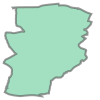

In [24]:
from shapely.geometry import shape 

shp = shape( gj )
shp

We can now use this region as a search limit over the OSM data, allowing us to retrieve just the road data that falls within the parish boundary.

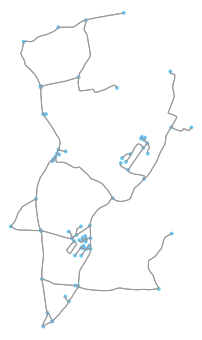

In [25]:
#see if we can load in all the roads within a particular parish
#select name from parish_region where name like "%arreton%"
parishroads = ox.graph_from_polygon(shp, network_type='drive')
ox.plot_graph(parishroads);

As well as rendering the roads inline, we can also generate an overlay for an interactive map. (The `folium` package is loaded as part of the `osmnx` load.)

It's a bit fiddly, but if you hover the cursor over the line just right, you can click to display a pop up containing the name of the road.

In [26]:
m=ox.plot_graph_folium(parishroads, popup_attribute='name', edge_width=2, tiles='openstreetmap')
m

In [208]:
folium.GeoJson(gj, name='geojson').add_to(m)
m

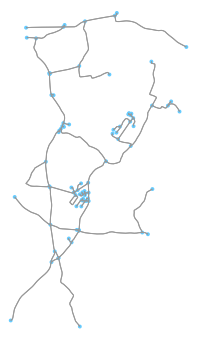

In [27]:
#This seems to retain everything to the extent of the boundary?
parishroads2 = ox.graph_from_polygon(shp, network_type='drive', truncate_by_edge=True, 
                                     clean_periphery=False, simplify=True)
ox.plot_graph(parishroads2);

In [30]:
parishroads2 = ox.graph_from_polygon(shp, network_type='drive', truncate_by_edge=True, 
                                     clean_periphery=False, simplify=True)
m2=folium.Map()
folium.GeoJson(gj, name='geojson').add_to(m2)
m2=ox.plot_graph_folium(parishroads2, graph_map=m2,popup_attribute='name', edge_width=2, tiles='openstreetmap')

m2

The data loaded in from OSM is represented as a `networkx` graph. This means we can do graph operations on it.

For example, how about trying to find routes that are walkable but not driveable?

We can get the walkable routes easily enough:

In [158]:
#Walkable routes in parish
parishwalks = ox.graph_from_polygon(shp, network_type='walk')

Now let's prune the walkable graph, and drop all the nodes in it that appear in the driveable graph.

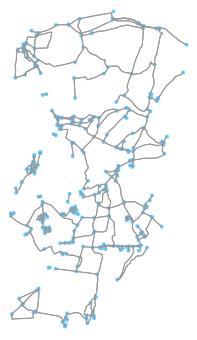

In [159]:
#walk not drive?
parishwalksnotdrive = parishwalks.copy()
#If a node is in the drive graph, remove it from the walk graph
parishwalksnotdrive.remove_nodes_from(n for n in parishwalks if n in parishroads)
ox.plot_graph(parishwalksnotdrive);

Once again, it's easy enough to render that as an interactive map:

In [160]:
ox.plot_graph_folium(parishwalksnotdrive, popup_attribute='name', edge_width=1)

## Plotting Building Footprints

As well as plotting routes, we can also use `osmnx` to grab and plot building outlines.

In [161]:
gdf = ox.buildings_from_polygon(shp)
gdf_proj = ox.project_gdf(gdf)

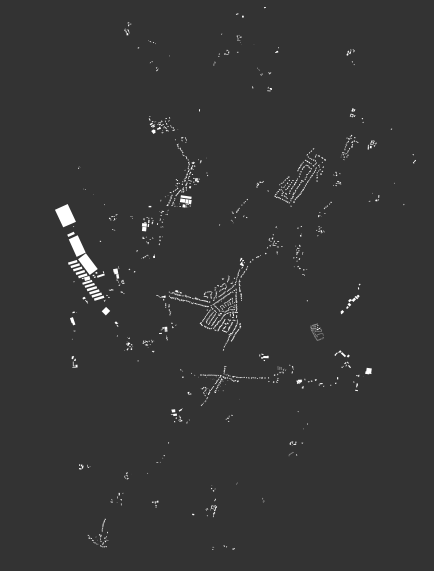

In [162]:
ox.plot_buildings(gdf_proj, bgcolor='#333333', color='w', dpi=40, figsize=(10,10));

The previous example shows how to grab data relating to the buildings that fall within an explicitly identified boundary, but we can also grab buildings within a specified distance of a particular location. That location can be identified as a point using latitude/longitude co-ordinates, or we can take the easy way out and geocode a particular address, using that as the central location.

The following function geocodes an address and then displays building footprints in the vicinity of it:

In [12]:
#via https://github.com/gboeing/osmnx-examples/blob/master/notebooks/10-building-footprints.ipynb
# helper function to get one-square-mile street networks, building footprints, and plot them
def plot_buildings_nearby( address, network_type='drive', bldg_color='orange', dpi=40,
                           dist=805, default_width=4, street_widths=None):
    gdf = ox.buildings_from_address(address=address,distance=dist)
    #The .project_gdf() method projects a GeoDataFrame to an appropriate UTM zone
    #I think this means the plot makes sense when presented as a 2d plot...
    gdf_proj = ox.project_gdf(gdf)
    fig, ax = ox.plot_figure_ground(address=address, dist=dist, network_type=network_type, default_width=default_width,
                                    street_widths=street_widths, save=False, show=False, close=True)
    fig, ax = ox.plot_buildings(gdf_proj, fig=fig, ax=ax, color=bldg_color, set_bounds=False,
                                 show=False, close=True, dpi=dpi)
    return fig

We can call the function with the address of the location we want to geocode:

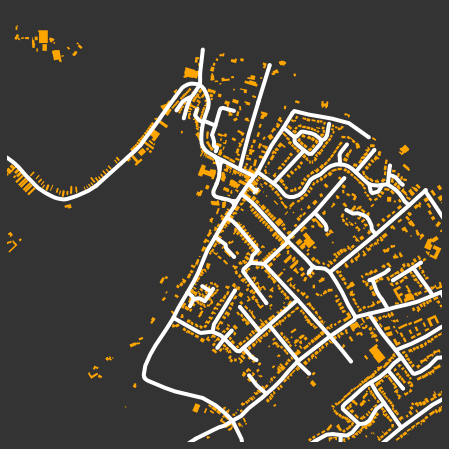

In [163]:
address = "Old Village Inn, Bembridge, Isle of Wight"
plot_buildings_nearby(address)

## Isochrone Maps

Isochrone maps highlight distances between locations. If you have a travel speed in mind for a particular mode of transport, then we can highlight areas within a particular travel time of a specified location.

(I wonder if we can get information back about road types - and assign different road speeds to them, e.g. as per MSA regulations?)

Let's find the location corresponding to a particular address and find the node nearest to it on the road network. In this example, I'm going to find walkable locations within half an hour or so of a nearby pub.

In [171]:
location=ox.utils.geocode('Pointer Inn, Newchurch, Isle of Wight')

#via https://github.com/gboeing/osmnx-examples/blob/master/notebooks/13-isolines-isochrones.ipynb
center_node = ox.get_nearest_node(parishwalks, location)

#The projection gets a projection with 
H = ox.project_graph(parishwalks)

Let's define some useful parameters, such as anticipated walking speed in km/h.

In [172]:
# add an edge attribute for time in minutes required to traverse each edge
travel_speed = 4.5

meters_per_minute = travel_speed * 1000 / 60 #km per hour to m per minute

#Generate a temporal distance measure for each edge
# I wonder if we could also use this in a route planner?
for u, v, k, data in H.edges(data=True, keys=True):
    data['time'] = data['length'] / meters_per_minute

Let's identify some different "temporal boundaries" - a 5 minute walk, for example, or 10, 15 or 30 minute walk.

In [188]:
trip_times = [5, 10, 15, 30] #in minutes
# get one color for each isochrone
iso_colors = ox.get_colors(n=len(trip_times), cmap='Reds', start=0.3, return_hex=True)

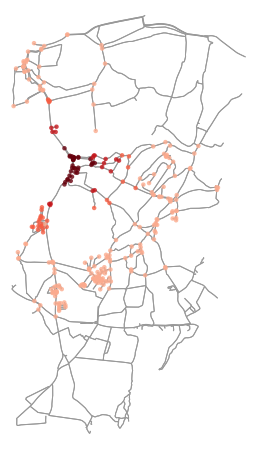

In [189]:
import networkx as nx

# color the nodes according to isochrone then plot the street network
node_colors = {}
for trip_time, color in zip(sorted(trip_times, reverse=True), iso_colors):
    subgraph = nx.ego_graph(H, center_node, radius=trip_time, distance='time')
    for node in subgraph.nodes():
        node_colors[node] = color

nc = [node_colors[node] if node in node_colors else 'none' for node in H.nodes()]
ns = [20 if node in node_colors else 0 for node in H.nodes()]
ox.plot_graph(H, fig_height=8, node_color=nc, node_size=ns, node_alpha=0.8, node_zorder=2);
#folium plot doesn't work as is for isochrone map?

So now I'm wondering how to generate a figure/ground plot showing all the buildings within a 30 minute walk of the address *Pointer Inn, Newchurch, Isle of Wight*!

As well as colouring nodes loosely relative to walking time, we can also generate an isochrone map that places isochrone areas onto the map. The [Isolines-Isochrones](https://github.com/gboeing/osmnx-examples/blob/master/notebooks/13-isolines-isochrones.ipynb) example notebook provides a function that does just that:

In [191]:
from shapely.geometry import LineString, Polygon, Point
from descartes import PolygonPatch
import geopandas as gpd

def make_iso_polys(G, edge_buff=25, node_buff=50, infill=False):
    isochrone_polys = []
    for trip_time in sorted(trip_times, reverse=True):
        subgraph = nx.ego_graph(G, center_node, radius=trip_time, distance='time')

        node_points = [Point((data['x'], data['y'])) for node, data in subgraph.nodes(data=True)]
        nodes_gdf = gpd.GeoDataFrame({'id': subgraph.nodes()}, geometry=node_points)
        nodes_gdf = nodes_gdf.set_index('id')

        edge_lines = []
        for n_fr, n_to in subgraph.edges():
            f = nodes_gdf.loc[n_fr].geometry
            t = nodes_gdf.loc[n_to].geometry
            edge_lines.append(LineString([f,t]))

        n = nodes_gdf.buffer(node_buff).geometry
        e = gpd.GeoSeries(edge_lines).buffer(edge_buff).geometry
        all_gs = list(n) + list(e)
        new_iso = gpd.GeoSeries(all_gs).unary_union
        
        # try to fill in surrounded areas so shapes will appear solid and blocks without white space inside them
        if infill:
            new_iso = Polygon(new_iso.exterior)
        isochrone_polys.append(new_iso)
    return isochrone_polys

Calling this function colours the map with boundary shapes associated with different walking times, overlaid on which are the walkable routes:

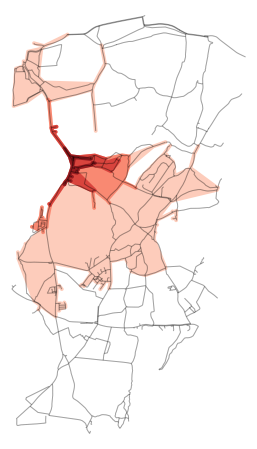

In [192]:
isochrone_polys = make_iso_polys(H, edge_buff=25, node_buff=0, infill=True)
fig, ax = ox.plot_graph(H, fig_height=8, show=False, close=False, edge_color='k', edge_alpha=0.2, node_color='none')
for polygon, fc in zip(isochrone_polys, iso_colors):
    patch = PolygonPatch(polygon, fc=fc, ec='none', alpha=0.6, zorder=-1)
    ax.add_patch(patch)

## Reflection

Living on a holiday island, I wonder if there's any mileage (!) in offering a simple service for campsites, hotels etc that would let them print off isochrone walking maps centred on the campsite, hotel etc with various points of interest, and estimated walking times, highlighted?

I'm also wondering how much work would be required in order to add additional support to the `osmnx` package so that it could use Ordnance Survey, rather than OSM, data?

One other thing I'd like to explore is how to generate [tulip diagrams](http://www.historicroadrally.co.uk/hrcr/navigation/tulips.htm) from route graphs.